# Optimizing App Offers With Starbucks
### Notebook 2: Clustering

In [1]:
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})

import boto3
import sagemaker

from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Custom colors that we will use in graphs:
custom_colors = ['#006241', '#84233C', '#1E3932', '#9D5116', '#E44C2C']

In [3]:
csv_file = 'data/clean_df.csv'
clean_df = pd.read_csv(csv_file)

clean_df.head()

,possible_reward,spent_required,duration,offer_type,offer_id,short_offer_id,duration_hrs,channel_email,channel_mobile,channel_social,...,days_of_membership,event,hours_after_start,money_spent,money_gained,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,event_auto_completed
0,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,A,168.0,1.0,1.0,1.0,...,527,offer received,408,NaN,NaN,0,1,0,0,0
1,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,A,168.0,1.0,1.0,1.0,...,527,offer viewed,408,NaN,NaN,0,0,1,0,0
2,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,A,168.0,1.0,1.0,1.0,...,381,offer received,168,NaN,NaN,0,1,0,0,0
3,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,A,168.0,1.0,1.0,1.0,...,420,offer received,576,NaN,NaN,0,1,0,0,0
4,10.0,10.0,7.0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,A,168.0,1.0,1.0,1.0,...,420,offer completed,684,54.61,10.0,1,0,1,1,0


In [4]:
list(clean_df.columns) 

['possible_reward',
 'spent_required',
 'duration',
 'offer_type',
 'offer_id',
 'short_offer_id',
 'duration_hrs',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'channel_web',
 'gender',
 'age',
 'person',
 'became_member_on',
 'income',
 'days_of_membership',
 'event',
 'hours_after_start',
 'money_spent',
 'money_gained',
 'event_offer_completed',
 'event_offer_received',
 'event_offer_viewed',
 'event_transaction',
 'event_auto_completed']

#### Drop the "unknown" customer data

See Data Exploration notebook for more info about "unknown" customers.

In [5]:
clean_df = clean_df[clean_df.age != -1]
clean_df.age.describe()

count    209030.000000
mean         53.318323
std          17.724360
min          18.000000
25%          40.000000
50%          54.000000
75%          66.000000
max         101.000000
Name: age, dtype: float64

#### Drop the columns that will not be used for clustering

Here we will drop all the columns that came from the offer data file (portfolio.json), because they represent information about the offers and not about the customers. We also don't need the "event_offer_received" column due to it's uninformativeness.

We will keep the columns with **demographic and consumer buying behavior** data.

In [6]:
columns_to_keep = ['gender',
 'age',
 'person',
 'income',
 'days_of_membership',
 'money_spent',
 'money_gained',
 'event_offer_completed',
 'event_offer_viewed',
 'event_transaction',
 'event_auto_completed']

clean_df = clean_df[columns_to_keep]
clean_df.sample(3)

,gender,age,person,income,days_of_membership,money_spent,money_gained,event_offer_completed,event_offer_viewed,event_transaction,event_auto_completed
63994,M,50,d830c27a96f04ce8bf9e196fbca3a6c1,82000.0,621,NaN,NaN,0,0,0,0
54720,F,57,32f08cbbcf93435d9c32b29833e47d55,81000.0,293,NaN,NaN,0,0,0,0
157609,M,76,7344225181ed4dea95b15cd053483382,46000.0,387,4.43,NaN,0,0,1,0


#### Encode "gender" using a one-hot encoding scheme

In [7]:
clean_df = clean_df.join(pd.get_dummies(clean_df['gender'])).drop('gender', axis=1) # drop the original column

for column in ['M', 'F', 'O']:
    clean_df = clean_df.rename(columns={column: ("gender_" + column.replace(" ", "_"))}) # rename new columns

clean_df.sample(3)

,age,person,income,days_of_membership,money_spent,money_gained,event_offer_completed,event_offer_viewed,event_transaction,event_auto_completed,gender_F,gender_M,gender_O
187609,85,ce3c8168b9464fd29c61275393390740,53000.0,1532,8.03,NaN,0,0,1,0,0,1,0
176776,59,436e0674e0094943aef62cfcfdb9d3c3,48000.0,654,21.59,NaN,0,0,1,0,0,1,0
214257,59,952f9040dd1c4c64a0a1ee4e42fe23eb,68000.0,924,13.82,NaN,0,0,1,0,1,0,0


In [8]:
list(clean_df.columns) 

['age',
 'person',
 'income',
 'days_of_membership',
 'money_spent',
 'money_gained',
 'event_offer_completed',
 'event_offer_viewed',
 'event_transaction',
 'event_auto_completed',
 'gender_F',
 'gender_M',
 'gender_O']

#### Group data by customer id

Our combined dataframe contains info about each event, but we want to cluster customers, not events, so we will aggregate the data for each customer.

In [9]:
# We use mean for some columns and sum for others
customer_df = clean_df.groupby(['person']).agg({'age':'mean',
                                                'income':'mean',
                                                'days_of_membership':'mean',
                                                'money_spent':'mean',
                                                'money_gained':'mean',
                                                'event_offer_completed':'sum',
                                                'event_offer_viewed':'sum',
                                                'event_transaction':'sum',
                                                'event_auto_completed':'sum',
                                                'gender_F':'mean',
                                                'gender_M':'mean',
                                                'gender_O':'mean'})

customer_df.sample(5)

,age,income,days_of_membership,money_spent,money_gained,event_offer_completed,event_offer_viewed,event_transaction,event_auto_completed,gender_F,gender_M,gender_O
person,,,,,,,,,,,,
8b5e47fbff5841518a90dee08cf42313,32,74000.0,99,3.706667,3.0,1,2,3,0,0,1,0
e433442492614997ad025b268178226c,27,39000.0,1411,3.187895,2.0,1,5,19,0,1,0,0
7c2384d9cb1d4226991554fc942a0963,49,74000.0,232,3.134000,NaN,0,4,5,0,0,1,0
4e898d4f879740d8a2d630b20f864b16,55,71000.0,490,19.196000,7.0,3,4,5,1,0,1,0
86e247f4637741d698eade285d30fa73,37,59000.0,359,11.594286,5.0,3,4,14,2,1,0,0


In [10]:
len(customer_df)

14825

#### Fill in missing values

We have some Null values in "money_spent" and "money_gained" columns. In both cases NaNs can be replaced with 0.00 which means zero purchases / zero money gained.

In [11]:
customer_df.isnull().sum()

age                         0
income                      0
days_of_membership          0
money_spent               333
money_gained             2839
event_offer_completed       0
event_offer_viewed          0
event_transaction           0
event_auto_completed        0
gender_F                    0
gender_M                    0
gender_O                    0
dtype: int64

In [12]:
customer_df = customer_df.fillna(0) 
customer_df.isnull().sum().sum() # should be 0

0

#### Data standardization

Two things we need to consider prior to selecting the data scaling algorithm:
1. Our data has outliers (average money spent)
2. Our data has negative values (missing age and income), which also happen to be outliers

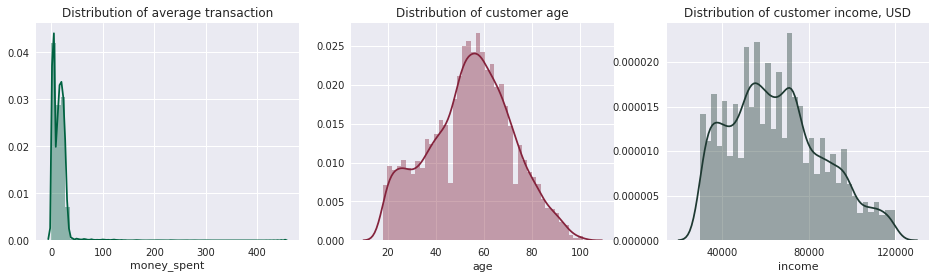

In [13]:
fig, ax = plt.subplots(1,3, figsize = (16, 4))

sns.distplot(customer_df['money_spent'], ax=ax[0], color=custom_colors[0])
sns.distplot(customer_df['age'], ax=ax[1], color=custom_colors[1])
sns.distplot(customer_df['income'], ax=ax[2],color=custom_colors[2])

ax[0].set_title('Distribution of average transaction', fontsize=12)
ax[1].set_title('Distribution of customer age', fontsize=12)
ax[2].set_title('Distribution of customer income, USD', fontsize=12)

ax[2].xaxis.set_major_locator(plt.MaxNLocator(4))

fig.show()

Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the **median and the interquartile range** often give better results (from https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler).

In [14]:
%%time

# RobustScaler removes the median and scales the data according to the quantile range (defaults to IQR).
# The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

scaler = RobustScaler()

# Fit to data (compute the median and quantiles to be used for scaling), then transform it:
customers_scaled = pd.DataFrame(scaler.fit_transform(customer_df.astype(float)))


customers_scaled.columns=customer_df.columns # keep column names
customers_scaled.index=customer_df.index # keep indices

CPU times: user 21.9 ms, sys: 845 µs, total: 22.8 ms
Wall time: 11.5 ms


In [15]:
customers_scaled.head()

,age,income,days_of_membership,money_spent,money_gained,event_offer_completed,event_offer_viewed,event_transaction,event_auto_completed,gender_F,gender_M,gender_O
person,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,-0.916667,0.258065,0.174873,0.096380,-0.272727,0.5,0.5,0.333333,2.0,0.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,-0.625000,-0.225806,-0.271647,0.108171,0.000000,1.0,1.0,-0.333333,0.0,0.0,-1.0,1.0
0020c2b971eb4e9188eac86d93036a77,0.166667,0.838710,0.876061,0.603282,0.545455,0.0,0.0,0.166667,0.0,1.0,-1.0,0.0
0020ccbbb6d84e358d3414a3ff76cffd,-1.291667,-0.129032,0.448217,-0.065350,0.090909,1.0,0.5,0.833333,0.0,1.0,-1.0,0.0
003d66b6608740288d6cc97a6903f4f0,-1.208333,0.290323,0.071307,-0.642063,-0.272727,1.0,0.5,1.833333,1.0,1.0,-1.0,0.0


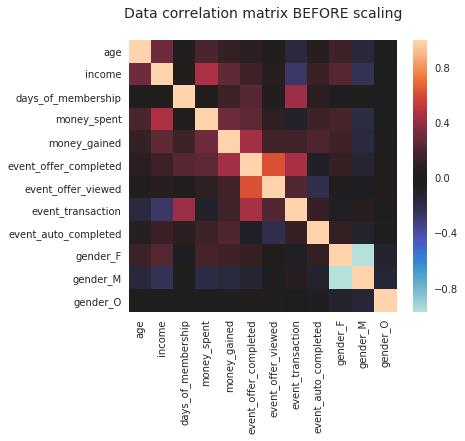

In [16]:
f, ax = plt.subplots(figsize = (6,5))

sns.heatmap(customer_df.corr(), center=0)
plt.title('Data correlation matrix BEFORE scaling\n', fontsize=14)

plt.show()

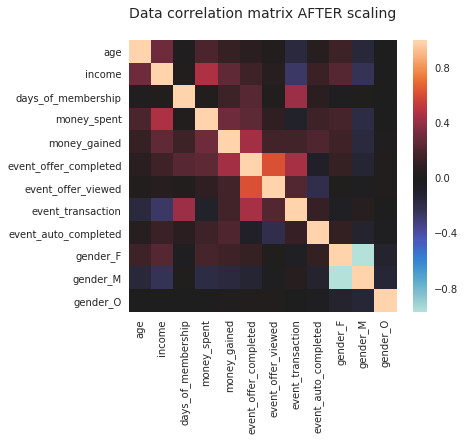

In [17]:
f, ax = plt.subplots(figsize = (6,5))

sns.heatmap(customers_scaled.corr(), center=0)
plt.title('Data correlation matrix AFTER scaling\n', fontsize=14)

plt.show()

#### Consider principal component analysis (PCA) implementation

PCA is most commonly used to condense the information contained in a large number of original variables into a smaller set of new composite dimensions, with a minimum loss of information.

PCA should be used mainly for variables which are strongly correlated. If the relationship is weak between variables, PCA does not work well to reduce data. In general, if most of the correlation coefficients are smaller than 0.3, PCA will not help (from https://www.originlab.com/doc/Origin-Help/PrincipleComp-Analysis).

In [18]:
print("Number of dimensions: {}".format(len(customers_scaled.columns)))

corr = customers_scaled.corr().abs() # return absolute value 

# Remove repetitive columns, stack the prescribed levels from columns to index
corr = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))


print("\nFeature pairs with no linear relationship: {}".format(len(corr[corr<0.3])))
print("Feature pairs with linear relationship: {}".format(len(corr[corr>=0.3])))

Number of dimensions: 12

Feature pairs with no linear relationship: 58
Feature pairs with linear relationship: 8


In our case there are **12 dimensions**, 7 of them representing 2 one-hot encoded categorical variables (gender and event type). K-means clustering with Amazon SageMaker can support large number of dimensions (such as 400 []) and we don't have a lot of strongly correlated columns. So our decision is to NOT implement principal component analysis for this data (from https://aws.amazon.com/blogs/machine-learning/k-means-clustering-with-amazon-sagemaker/).

#### Create formatted, k-means training data

We need to convert the data into a numpy array and then into a RecordSet. This is the required format for passing training data into a KMeans model in Sagemaker.

In [19]:
kmeans_train_data_np = customers_scaled.values.astype('float32')

In [20]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store current SageMaker session
bucket_name = session.default_bucket()
print(bucket_name)

role = get_execution_role() # get IAM role
print(role)

sagemaker-us-east-1-037802178319
arn:aws:iam::037802178319:role/service-role/AmazonSageMaker-ExecutionRole-20190808T112563


### Data clustering implementation

#### Identify optimal k for k-means using the elbow method

In [21]:
%%time

from sagemaker import KMeans
from time import gmtime, strftime
    
K = range(2, 16)
prefix = 's3://{}/starbucks/output/'.format(bucket_name)

def train_for_elbow(K, prefix):
    '''Launches the training jobs for different k values
    Args:
        K: range of k numbers (e.g. range(2,10))
        prefix: S3 bucket and prefix (e.g. 's3://bucket/starbucks/output/')
    Returns:
        output_folder: a folder name with all saved models (string)
    '''
    output_time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
    output_folder = 'kmeans-' + output_time
    output_location = prefix + output_folder
    
    for k in K:
        print('Starting train job for k=' + str(k))
        print('Training artifacts will be uploaded to: {}'.format(output_location))

        kmeans = KMeans(role=role,
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    output_path=output_location,         
                    k=k)

        kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

        kmeans.fit(kmeans_formatted_data)
        
    return output_folder

output_folder = train_for_elbow(K, prefix)

Starting train job for k=2
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-037802178319/starbucks/output/kmeans-2020-02-01-17-31-49
2020-02-01 17:31:50 Starting - Starting the training job...
2020-02-01 17:31:51 Starting - Launching requested ML instances......
2020-02-01 17:32:53 Starting - Preparing the instances for training......
2020-02-01 17:34:02 Downloading - Downloading input data...
2020-02-01 17:34:34 Training - Downloading the training image.Docker entrypoint called with argument(s): train
[02/01/2020 17:34:56 INFO 140511802455872] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'loca

In [22]:
# Save all model paths to a list:
keys = []

prefix = "starbucks/output/" + output_folder
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)

for obj in bucket.objects.filter(Prefix=prefix):
    keys.append(obj.key)
    
keys

['starbucks/output/kmeans-2020-02-01-17-31-49/kmeans-2020-02-01-17-31-50-013/output/model.tar.gz',
 'starbucks/output/kmeans-2020-02-01-17-31-49/kmeans-2020-02-01-17-35-33-113/output/model.tar.gz',
 'starbucks/output/kmeans-2020-02-01-17-31-49/kmeans-2020-02-01-17-39-15-836/output/model.tar.gz',
 'starbucks/output/kmeans-2020-02-01-17-31-49/kmeans-2020-02-01-17-42-58-868/output/model.tar.gz',
 'starbucks/output/kmeans-2020-02-01-17-31-49/kmeans-2020-02-01-17-46-41-618/output/model.tar.gz',
 'starbucks/output/kmeans-2020-02-01-17-31-49/kmeans-2020-02-01-17-50-24-217/output/model.tar.gz',
 'starbucks/output/kmeans-2020-02-01-17-31-49/kmeans-2020-02-01-17-54-07-016/output/model.tar.gz',
 'starbucks/output/kmeans-2020-02-01-17-31-49/kmeans-2020-02-01-17-57-49-852/output/model.tar.gz',
 'starbucks/output/kmeans-2020-02-01-17-31-49/kmeans-2020-02-01-18-01-02-823/output/model.tar.gz',
 'starbucks/output/kmeans-2020-02-01-17-31-49/kmeans-2020-02-01-18-04-45-696/output/model.tar.gz',
 'starbuck

model_algo-1
state_040bc648-c1f1-41ad-883c-bd17f1cfc0c6
state_e7130caf-a76d-47f0-990b-8fd2715ed048
model_algo-1
model_algo-1
state_5bb1478d-67a6-40f8-8bdb-c6b687992886
state_d9f88e92-72b3-44d8-9653-3a295b8bcfa3
model_algo-1
state_17e306f3-9958-4832-b2dd-ca45ea21a70e
model_algo-1
state_1fae3777-2833-4a6b-9cb6-a247eee59523
model_algo-1
model_algo-1
state_15aa9a42-c5a2-4086-9abd-d95094f0ab02
model_algo-1
state_83de7b6c-551f-4c87-bbda-aa0340ec141d
state_010e05e5-cdf6-44cc-a3de-10fd6787f9e2
model_algo-1
model_algo-1
state_e64dd00c-82ab-4e29-bad6-dc2b3f0ed3a2
state_03586f8c-0575-4eef-91e6-725a367869fc
model_algo-1
state_da9daf8d-bd82-46c7-bbdc-2fb981ff3129
model_algo-1
state_dd3ac684-0688-4b8e-bd87-b8146261a413
model_algo-1
state_76aa1baa-d517-4fa9-be35-c5bdcaff0116
model_algo-1


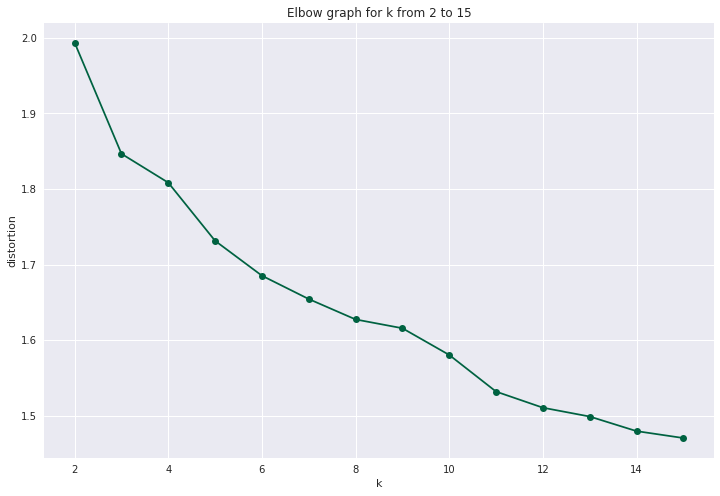

In [24]:
import mxnet as mx
from scipy.spatial.distance import cdist

def elbow_plot(K, keys):
    '''Draws the elbow graph for k-means
    Args:
        K: range of k numbers
        keys: list of S3 folders with saved model for each k (in the same order as K)
    Returns:
        None
    '''
    plt.figure(figsize=(12,8))
    models = {}
    distortions = []
    i = 0

    for k in K:
        s3_client = boto3.client('s3')
        key = keys[i]
        s3_client.download_file(bucket_name, key, 'model.tar.gz')
        !tar -xvf model.tar.gz                       
        kmeans_model=mx.ndarray.load('model_algo-1')
        kmeans_numpy = kmeans_model[0].asnumpy()
        distortions.append(sum(np.min(cdist(kmeans_train_data_np, kmeans_numpy, 'euclidean'),
                                      axis=1)) / kmeans_train_data_np.shape[0])
        models[k] = kmeans_numpy
        i+=1

    # Plot the elbow
    plt.plot(K, distortions, 'bx-', color=custom_colors[0], marker="o")
    plt.xlabel('k')
    plt.ylabel('distortion')
    plt.title('Elbow graph for k from {} to {}'.format(K[0], K[-1]))
    plt.show()
    
    return
    
elbow_plot(K, keys)

In the graph we plot the Euclidean distance to the cluster centroid. You can see that the error decreases as k gets larger. This is because when the number of clusters increases, they should be smaller, so distortion is also smaller. This produces an “elbow effect” in the graph. The idea of the elbow method is to choose **the k at which the rate of decrease sharply shifts** (from https://aws.amazon.com/blogs/machine-learning/k-means-clustering-with-amazon-sagemaker/).

Based on the graph above, k=3 would be a good cluster size for this dataset. 

### Deploy the k-means model

In [25]:
%%time

prefix = 's3://{}/starbucks/output/'.format(bucket_name)
output_time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_folder = 'kmeans-' + output_time
output_location = prefix + output_folder

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_location,         
                k=3)

kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

kmeans.fit(kmeans_formatted_data)

kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

2020-02-01 18:39:55 Starting - Starting the training job...
2020-02-01 18:39:57 Starting - Launching requested ML instances......
2020-02-01 18:41:02 Starting - Preparing the instances for training...
2020-02-01 18:41:52 Downloading - Downloading input data......
2020-02-01 18:42:53 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[02/01/2020 18:42:56 INFO 140548305753920] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]'

#### Pass in the training data and assign predicted cluster labels

In [26]:
cluster_info=kmeans_predictor.predict(kmeans_train_data_np)

In [29]:
# Print cluster info for the first customer
data_idx = 0

print('Customer: ', customer_df.index[data_idx])
print()
print(cluster_info[data_idx])

Customer:  0009655768c64bdeb2e877511632db8f

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 0.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 2.1368730068206787
    }
  }
}



#### Shut down the endpoint

In [30]:
kmeans_predictor.delete_endpoint()

### Explore the resultant clusters

In [31]:
# Get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

# Add cluster info to our initial dataframe:
customer_df['CLOSEST_CLUSTER'] = list(map(int, cluster_labels))
customer_df.head(3)

,age,income,days_of_membership,money_spent,money_gained,event_offer_completed,event_offer_viewed,event_transaction,event_auto_completed,gender_F,gender_M,gender_O,CLOSEST_CLUSTER
person,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,33,72000.0,545,15.684444,3.0,3,4,9,2,0,1,0,0
0011e0d4e6b944f998e987f904e8c1e5,40,57000.0,282,15.892000,4.0,4,5,5,0,0,0,1,0
0020c2b971eb4e9188eac86d93036a77,59,90000.0,958,24.607500,6.0,2,3,8,0,1,0,0,1


In [32]:
### FILE SAVING CHECKPOINT ###
filename = 'data/customer_df_kmeans.csv'
customer_df.to_csv(filename) 

In [3]:
# Uncomment to load:
customer_df = pd.read_csv('data/customer_df_kmeans.csv')
customer_df.head(3)

,person,age,income,days_of_membership,money_spent,money_gained,event_offer_completed,event_offer_viewed,event_transaction,event_auto_completed,gender_F,gender_M,gender_O,CLOSEST_CLUSTER
0,0009655768c64bdeb2e877511632db8f,33,72000.0,545,15.684444,3.0,3,4,9,2,0,1,0,0
1,0011e0d4e6b944f998e987f904e8c1e5,40,57000.0,282,15.892000,4.0,4,5,5,0,0,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,59,90000.0,958,24.607500,6.0,2,3,8,0,1,0,0,1


#### Revert one-hot encoded columns back to categorical

In [4]:
customer_df = customer_df.rename(columns={"gender_F": "Female",
                                          "gender_M": "Male",
                                          "gender_O": "Other"})
gender = customer_df[['Female','Male','Other']]
gender = pd.DataFrame(gender.idxmax(1))

customer_df = customer_df.rename(columns={"event_offer_completed": "offer completed",
                                          "event_offer_viewed": "offer ignored",
                                          "event_transaction": "casual purchase",
                                          "event_auto_completed": "offer auto completed"})
event = customer_df[['offer completed','offer ignored','casual purchase','offer auto completed']]
event = pd.DataFrame(event.idxmax(1))

customer_df['gender'] = gender[0]
customer_df['event'] = event[0]

In [5]:
# Pretify cluster column for plotting:

customer_df["CLUSTER"] = customer_df["CLOSEST_CLUSTER"]

customer_df["CLUSTER"] = customer_df["CLUSTER"].replace(0, "A")
customer_df["CLUSTER"] = customer_df["CLUSTER"].replace(1, "B")
customer_df["CLUSTER"] = customer_df["CLUSTER"].replace(2, "C")

customer_df = customer_df.sort_values(by=['CLOSEST_CLUSTER'])

customer_df.sample(3)

,person,age,income,days_of_membership,money_spent,money_gained,offer completed,offer ignored,casual purchase,offer auto completed,Female,Male,Other,CLOSEST_CLUSTER,gender,event,CLUSTER
8853,9831341c3d0840219ce2b4cd6ac0dd54,40,33000.0,1608,6.970526,5.000000,1,4,19,0,1,0,0,0,Female,casual purchase,A
1432,1943d34100274155a01626b5940fbf38,86,78000.0,549,25.922000,3.333333,3,4,5,0,0,1,0,1,Male,casual purchase,B
9321,9f9eb9386d71451bb751acee1ab3603d,53,57000.0,240,13.457500,10.000000,2,5,4,0,0,1,0,1,Male,offer ignored,B


In [6]:
### FILE SAVING CHECKPOINT ###
filename = 'data/customer_df_kmeans_smalldim.csv'
customer_df.to_csv(filename) 

In [7]:
# Uncomment to load:
customer_df = pd.read_csv('data/customer_df_kmeans_smalldim.csv', index_col=0)
customer_df.sample(3)

,person,age,income,days_of_membership,money_spent,money_gained,offer completed,offer ignored,casual purchase,offer auto completed,Female,Male,Other,CLOSEST_CLUSTER,gender,event,CLUSTER
2926,331c92564c2d4a2f8ca31bbc61305153,35,35000.0,860,2.729000,5.0,1,4,10,1,0,1,0,0,Male,casual purchase,A
13359,e6590c7f954f4ff482c069b45070b351,28,68000.0,1850,12.272143,5.0,1,4,14,0,0,1,0,0,Male,casual purchase,A
574,0a3a378dedac4d5f80aa616e5c8007b3,51,86000.0,422,27.392500,5.0,1,3,4,0,1,0,0,1,Female,casual purchase,B


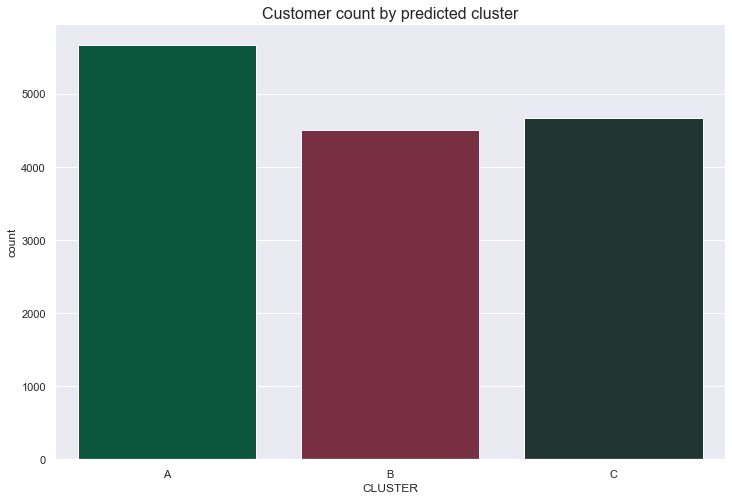

In [8]:
sns.countplot(x="CLUSTER", data=customer_df, palette=custom_colors)
plt.title("Customer count by predicted cluster", fontsize=16)
plt.show()

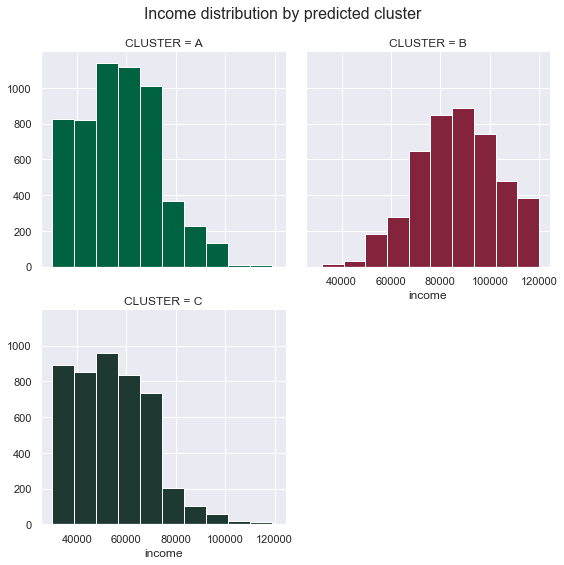

In [9]:
g = sns.FacetGrid(customer_df, col='CLUSTER', col_wrap=2, height = 4, hue='CLUSTER', palette=custom_colors)
g.map(plt.hist, "income")

plt.subplots_adjust(top=0.9) # fix title position
g.fig.suptitle("Income distribution by predicted cluster", fontsize=16)

plt.show()

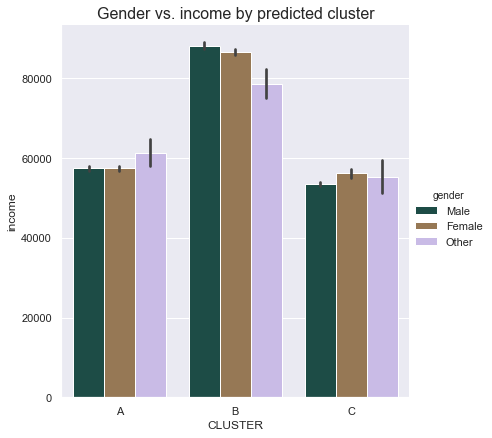

In [10]:
sns.catplot(x='CLUSTER', y='income', hue="gender", data=customer_df[customer_df.gender != "Unknown"],
                height=6, kind="bar", palette="cubehelix")
plt.title("Gender vs. income by predicted cluster", fontsize=16)
plt.show()

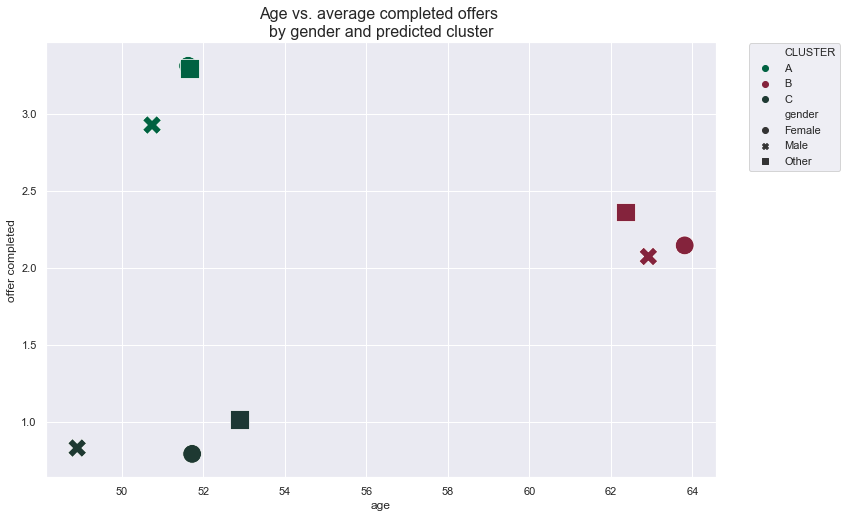

In [28]:
group = customer_df.groupby(['CLUSTER', 'gender'], as_index=False).mean()

sns.scatterplot(x="age", y="offer completed",
                data=group,
                hue="CLUSTER",
                palette=custom_colors[:-2],
                style="gender",
                s=350)

plt.legend(loc=(1.05,0.705))
    
plt.title("Age vs. average completed offers \nby gender and predicted cluster", fontsize=16)

plt.show()

In the graph above we observe the clustering results after grouping the customers by gender. Mean age of all three groups is above 40 years old, which is also true for our initial dataset. Cluster "A" customers complete more offers on average than cluster "C". Cluster "B" is in between in terms of completing offers and has older members compared to "A" and "C". 

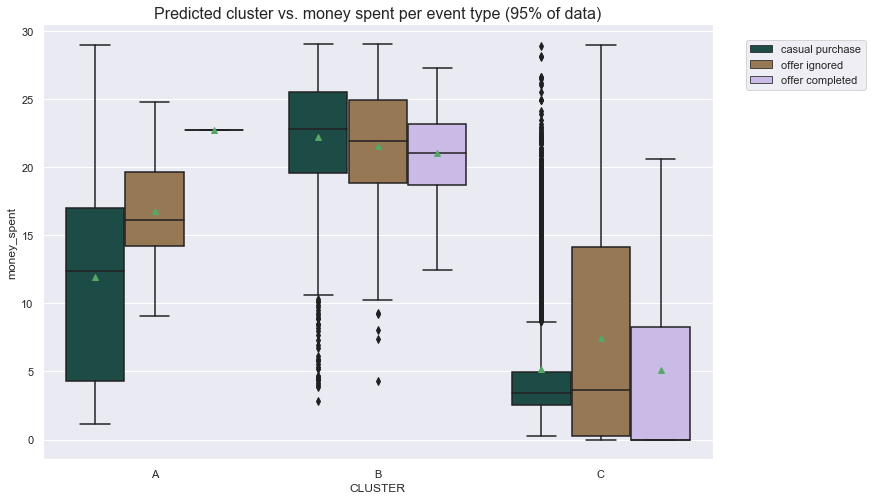

In [26]:
data = customer_df[customer_df.money_spent < customer_df.money_spent.quantile(0.95)]
sns.boxplot(x="CLUSTER", y="money_spent", hue="event", data=data, showmeans=True, palette="cubehelix")

plt.legend(loc=(1.05,0.85))

plt.title("Predicted cluster vs. money spent per event type (95% of data)", fontsize=16)

plt.show()

Here we can look at each cluster purchasing patterns. Cluster "A" had the most clients who make purchases without any promotional offers, spending between 5 and 18 USD in general. Cluster "C" completes a lot of offers but doesn't spend much on them. Cluster **"B" is spending the most**, with both casual and promotional purchases over 18 USD per transaction, which makes it our **target of interest cluster**.

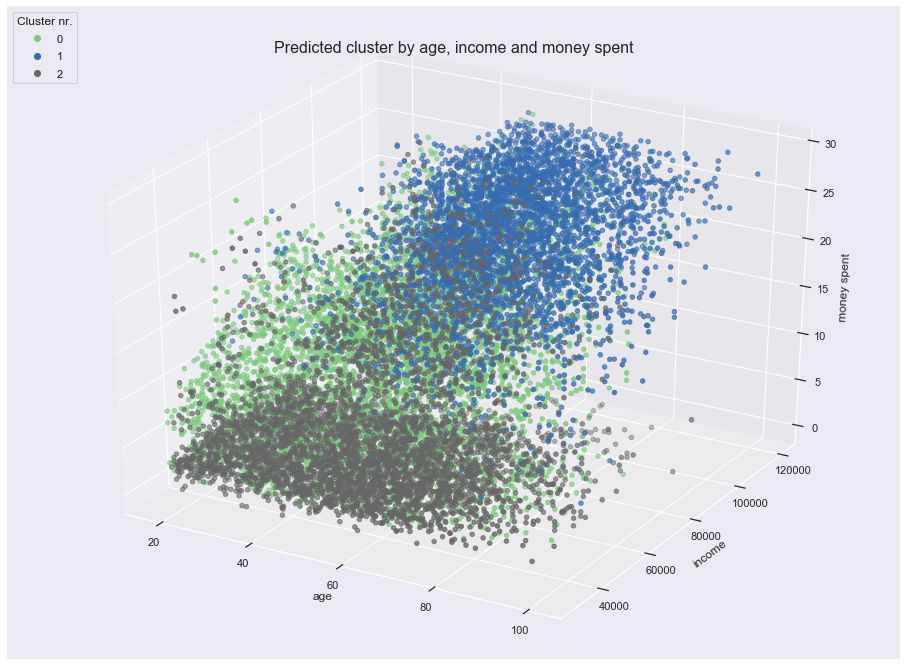

In [63]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,12))
ax = fig.gca(projection='3d')

scatter = ax.scatter(data['age'], data['income'], data['money_spent'], 
           c=data['CLOSEST_CLUSTER'], cmap="Accent")

# produce a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Cluster nr.")
ax.add_artist(legend)

ax.set_xlabel('age')
ax.set_ylabel('income')
ax.set_zlabel('money spent')

plt.title("Predicted cluster by age, income and money spent", fontsize=16)

plt.show()

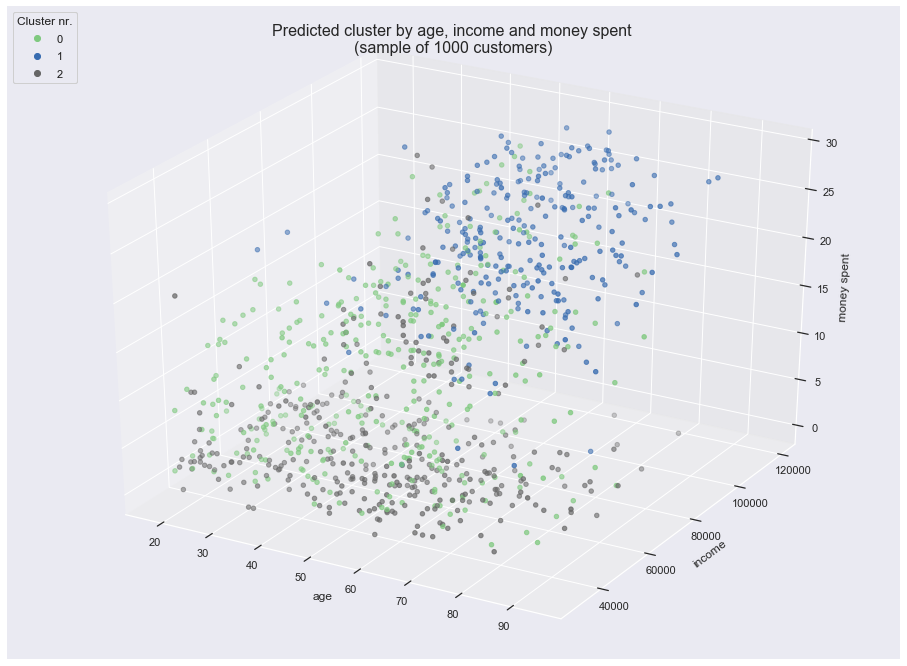

In [65]:
sample = data.sample(1000)

fig = plt.figure(figsize=(16,12))
ax = fig.gca(projection='3d')

scatter = ax.scatter(sample['age'], sample['income'], sample['money_spent'], 
           c=sample['CLOSEST_CLUSTER'], cmap="Accent")

# produce a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Cluster nr.")
ax.add_artist(legend)

ax.set_xlabel('age')
ax.set_ylabel('income')
ax.set_zlabel('money spent')

plt.title("Predicted cluster by age, income and money spent \n(sample of 1000 customers)", fontsize=16)

plt.show()

If we look at all data points across 3 dimensions - age, income and money spent, we can also confirm that our target cluster is 1 (or "B"). Customers in this cluster have both **higher income and higher spendings**. Cluster 0 (or "A") is located somewhere in between and we have to remember from previous visualization that these clients are not really sensitive to offers. Cluster 2 (or "C") has a lower income and less spending customers.

This project will not focus on building marketing campaigns, but for the purpose of example cluster interpretation could look like this:

- Cluster "A" - Send informational offers once a month
- Cluster "B" - Send different offer types, one offer in two weeks
- Cluster "C" - Send money saving promotions (BOGO and discount) every week

___
Please refer to [PROJECT REPORT](https://evanca.github.io/machine-learning_optimizing-app-offers-with-starbucks/) for a conclusions and a high-level overview of the full project.